### data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os

In [3]:
def load_generation_data(include_files=None, date_filter=None):
    data_dir = "/Users/jangseohyun/Documents/workspace/symply/DER/data/generation"
    all_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.csv')])

    if include_files is not None:
        for file in include_files:
            if file not in all_files:
                raise ValueError(f"파일을 찾을 수 없습니다: {file}")
        files_to_load = [f for f in all_files if f in include_files]
    else:
        files_to_load = all_files

    I = len(files_to_load)  
    T = 24 
    generation_data = np.zeros((I, T)) 

    loaded_files = []
    
    for idx, file in enumerate(files_to_load):
        file_path = os.path.join(data_dir, file)
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip()

        date_col = "Date"
        hour_col = "Hour (Eastern Time, Daylight-Adjusted)"
        gen_col = "Electricity Generated"

        if any(col not in df.columns for col in [date_col, hour_col, gen_col]):
            print(f"{file}: 필요한 컬럼 없음. 스킵됨.")
            continue

        if date_filter:
            df = df[df[date_col] == date_filter]
            if df.empty:
                print(f"{file}: {date_filter} 데이터 없음. 스킵됨.")
                continue 

        df = df[df[hour_col].astype(str).str.match(r'^\d+$')]
        df["Time"] = df[hour_col].astype(int)
        df = df[df["Time"].between(0, 23)]

        for t in range(T):
            if t in df["Time"].values:
                generation_data[idx, t] = df[df["Time"] == t][gen_col].values[0]

        loaded_files.append(file)

    print(f"✅ 총 {I}개 파일을 불러왔습니다: {', '.join(loaded_files)}")

    return generation_data, I, T

def generate_randomized_generation(I, T, S, data, randomness_level):
    np.random.seed(7)

    noise_ranges = {
        "low": (0.8, 1.2),
        "medium": (0.5, 1.5),
        "high": (0.2, 1.8),
    }

    if randomness_level not in noise_ranges:
        raise ValueError("Invalid randomness level. Please choose 'low', 'medium', or 'high'.")

    low, high = noise_ranges[randomness_level]
    noise_factors = np.random.uniform(low, high, size=(I, T, S))

    generation_r = np.expand_dims(data, axis=-1) * noise_factors
    
    print(f"📊 데이터 Shape: I={I}, T={T}, S={S}")
    return generation_r

def plot_generation_data(generation_data, I):
    hours = np.arange(24)
    plt.figure(figsize=(15, 9))

    for i in range(I):
        plt.plot(hours, generation_data[i], marker='o', linestyle='-', alpha=0.7, label=f'Generator {i}')

    plt.xlabel("Hour")
    plt.ylabel("Electricity Generated (kWh)")
    plt.title("Hourly Electricity Generation for All Generators")
    plt.xticks(hours)  # 0~23 시간 설정
    plt.legend(loc="upper left", fontsize='small')

    plt.show()

def plot_randomized_generation(R, I, T, S):
    hours = np.arange(T)
    
    plt.figure(figsize=(15, 9))

    for i in range(I):
        plt.plot(hours, R[i, :, S], marker='o', linestyle='-', alpha=0.7, label=f'Generator {i}')

    plt.xlabel("Hour")
    plt.ylabel("Electricity Generated (kWh)")
    plt.title(f"Randomized Hourly Generation for Scenario {S}")
    plt.xticks(hours) 
    plt.legend(loc="upper left") 

    plt.show()
       
def plot_scenarios_for_generator(R, i):

    T = R.shape[1]
    S = R.shape[2] 
    hours = np.arange(T) 

    plt.figure(figsize=(15, 9))

    for s in range(S):
        plt.plot(hours, R[i, :, s], linestyle='-', alpha=0.6, label=f'Scenario {s+1}')

    plt.xlabel("Hour")
    plt.ylabel("Electricity Generated (kWh)")
    plt.title(f"Hourly Electricity Generation for Generator {i} Across All Scenarios")
    plt.xticks(hours)
    plt.legend(loc="upper left", fontsize='small', ncol=2)
    plt.show()

def generate_rt_scenarios(rt_da, S, randomness_level):

    rt_da["Time Stamp"] = pd.to_datetime(rt_da["Time Stamp"])
    nyc_rt = rt_da[rt_da["Name"] == "N.Y.C."].copy() 

    nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")
    hourly_avg = nyc_rt.groupby("Hour")["LBMP ($/MWHr)"].mean().reset_index()
    price_hourly = hourly_avg["LBMP ($/MWHr)"].to_numpy()
    T = len(price_hourly)

    np.random.seed(17)
    noise_ranges = {
        "low": (0.95, 1.05),
        "medium": (0.85, 1.15),
        "high": (0.7, 1.3),
    }

    if randomness_level not in noise_ranges:
        raise ValueError("Invalid randomness level. Choose from 'low', 'medium', 'high'.")

    low, high = noise_ranges[randomness_level]
    noise_factors = np.random.uniform(low, high, size=(T, S))

    P_RT = np.expand_dims(price_hourly, axis=-1) * noise_factors

    return P_RT

def plot_rt_scenarios(P_RT):
    T, S = P_RT.shape
    hours = np.arange(T)

    plt.figure(figsize=(15, 8))

    for s in range(S):
        plt.plot(hours, P_RT[:, s], linestyle='-', alpha=0.6, label=f"Scenario {s+1}")

    plt.xlabel("Hour")
    plt.ylabel("Price ($/MWHr)")
    plt.title("Real-Time Price Scenarios (Hourly Averaged)")
    plt.xticks(hours)
    plt.legend(loc="upper left", fontsize="small", ncol=2)

    plt.show()
    
only_profit = np.array(pd.read_csv("result/result_only_profit.csv"))
ny_da = pd.read_csv("/Users/jangseohyun/Documents/workspace/symply/DER/data/price/20220718da.csv")
ny_rt = pd.read_csv("/Users/jangseohyun/Documents/workspace/symply/DER/data/price/20220718rt.csv")
ny_da["Time Stamp"] = pd.to_datetime(ny_da["Time Stamp"])
ny_da["Hour"] = ny_da["Time Stamp"].dt.hour
nyc_data = ny_da[ny_da["Name"] == "N.Y.C."]
P_DA = nyc_data["LBMP ($/MWHr)"].to_numpy() * 1.3
P_PN = P_DA * 1.5

# plot_generation_data(generation_data, 10)
# plot_randomized_generation(R, I, T, 7)
# plot_scenarios_for_generator(R, 1)
# plot_rt_scenarios(P_RT)

# include_files = ['1201.csv', '137.csv', '281.csv', '397.csv', '401.csv', '430.csv', '514.csv', '524.csv', '775.csv', '89.csv']
include_files = ['1201.csv', '137.csv', '401.csv', '524.csv', '89.csv']
generation_data, I, T = load_generation_data(include_files, "2022-07-18")

S = 20
randomness_level = "medium"
R = generate_randomized_generation(I, T, S, generation_data, randomness_level)
P_RT = generate_rt_scenarios(ny_rt, S, randomness_level)


✅ 총 5개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv, 524.csv, 89.csv
📊 데이터 Shape: I=5, T=24, S=20


/var/folders/2_/9m9qjphn0xs45xzpvf1hl0j00000gn/T/ipykernel_4590/2046979868.py:126: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")


### settlement model

In [4]:
set = gp.Model("Settlement")
set.setParam("PoolSolutions", 15)
set.setParam("PoolSearchMode", 2)
set.setParam("PoolGap", 0.05)

alpha = set.addVars(T, vtype=GRB.CONTINUOUS, lb=0, name="alpha")
x = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="x")
y_plus = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
y_minus = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
M_y = max(R[i, t, s] for i in range(I) for t in range(T) for s in range(S))
z_y = set.addVars(I, T, S, vtype=GRB.BINARY, name="z_y")

d = set.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")
e_plus = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="e_plus")
e_minus = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="e_minus")
M_e = max(sum(R[i, t, s] for i in range(I)) for t in range(T) for s in range(S))
z_e = set.addVars(T, S, vtype=GRB.BINARY, name="z_e") 
set.update()

obj = 1/S * gp.quicksum(
    P_DA[t] * gp.quicksum(x[i, t, s] for i in range(I) for s in range(S)) for t in range(T)
) + 1/S * gp.quicksum(
    P_RT[t, s] * e_plus[i, t, s] for i in range(I) for t in range(T) for s in range(S)
) - 1/S * gp.quicksum(
    P_PN[t] * gp.quicksum(e_minus[i, t, s] for i in range(I) for s in range(S)) for t in range(T)
)

set.setObjective(obj, GRB.MAXIMIZE)

Set parameter Username
Set parameter LicenseID to value 2611964
Academic license - for non-commercial use only - expires 2026-01-20
Set parameter PoolSolutions to value 15
Set parameter PoolSearchMode to value 2
Set parameter PoolGap to value 0.05


In [5]:
# x의 합은 alpha
for t in range(T):
    for s in range(S):
        set.addConstr(alpha[t] == gp.quicksum(x[i, t, s] for i in range(I)))

# x로 y+, y- 결정 지어주기
for i in range(I):
    for t in range(T):
        for s in range(S):
            set.addConstr(R[i, t, s] - x[i, t, s] == y_plus[i, t, s] - y_minus[i, t, s])

# y+, y- 둘 중 하나는 0이어야함
for i in range(I):
    for t in range(T):
        for s in range(S):
            set.addConstr(y_plus[i, t, s] <= M_y * z_y[i, t, s])
            set.addConstr(y_minus[i, t, s] <= M_y * (1 - z_y[i, t, s]))

# rt 조건
for i in range(I):
    for t in range(T):
        for s in range(S):
            set.addConstr(y_plus[i, t, s] <= R[i, t, s])

# sum e+, sum e- 결정 지어주기
for t in range(T):
    for s in range(S):
        set.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) - gp.quicksum(x[i, t, s] for i in range(I)) 
                    == gp.quicksum(e_plus[i, t, s] for i in range(I)) - gp.quicksum(e_minus[i, t, s] for i in range(I)))

# sum e+, sum e- 둘 중 하나는 0이어야 함
for t in range(T):
    for s in range(S):
        set.addConstr(gp.quicksum(e_plus[i, t, s] for i in range(I)) <= M_e * z_e[t, s])
        set.addConstr(gp.quicksum(e_minus[i, t, s] for i in range(I)) <= M_e * (1 - z_e[t, s]))

# sum e+ <= sum R
for t in range(T):
    for s in range(S):
        set.addConstr(gp.quicksum(e_plus[i, t, s] for i in range(I)) <= gp.quicksum(R[i, t, s] for i in range(I)))

# e+, e- 정의
for i in range(I):
    for t in range(T):
        for s in range(S):
            # e_plus: 초과량에서 준 양을 뺀 것
            set.addConstr(
                e_plus[i,t,s] == y_plus[i,t,s] - gp.quicksum(d[i,j,t,s] for j in range(I) if j != i)
            )
            # e_minus: 부족량에서 받은 양을 뺀 것
            set.addConstr(
                e_minus[i,t,s] == y_minus[i,t,s] - gp.quicksum(d[j,i,t,s] for j in range(I) if j != i)
            )

# 전력 이동 제한
for i in range(I):
    for t in range(T):
        for s in range(S):
            # 본인이 주는 양은 자신의 y+을 넘을 수 없음
            set.addConstr(
                gp.quicksum(d[i, j, t, s] for j in range(I) if j != i)
                <= y_plus[i, t, s]
            )
            # 본인이 받는 양은 자신의 y-을 넘을 수 없음
            set.addConstr(
                gp.quicksum(d[j, i, t, s] for j in range(I) if j != i)
                <= y_minus[i, t, s]
            )

# 자기 자신과의 거래 방지
for i in range(I):
    for t in range(T):
        for s in range(S):
            set.addConstr(d[i, i, t, s] == 0)

In [6]:
set.optimize()

if set.status == GRB.OPTIMAL:
    alpha_vals = np.array([alpha[t].x for t in range(T)])
    x_vals = np.array(
        [[[x[i, t, s].x for s in range(S)] for t in range(T)] for i in range(I)]
    )
    y_plus_vals = np.array(
        [[[y_plus[i, t, s].x for s in range(S)] for t in range(T)] for i in range(I)]
    )
    y_minus_vals = np.array(
        [[[y_minus[i, t, s].x for s in range(S)] for t in range(T)] for i in range(I)]
    )
    d_vals = np.array(
        [
            [[[d[i, j, t, s].x for s in range(S)] for t in range(T)] for j in range(I)]
            for i in range(I)
        ]
    )
    e_plus_vals = np.array(
        [[[e_plus[i, t, s].x for s in range(S)] for t in range(T)] for i in range(I)]
    )
    e_minus_vals = np.array(
        [[[e_minus[i, t, s].x for s in range(S)] for t in range(T)] for i in range(I)]
    )
    print("\n- - - - - - - - - - - - - - - - - - - - - - - -")
    print("Optimal solution found!")
    print(set.objVal)
    print(f"Optimality Gap: {set.MIPGap}")
else:
    print("\nNo optimal solution found.")

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
PoolSolutions  15
PoolSearchMode  2
PoolGap  0.05

Optimize a model with 24000 rows, 26904 columns and 92640 nonzeros
Model fingerprint: 0x42cdc73a
Variable types: 24024 continuous, 2880 integer (2880 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 2e+03]
Presolve removed 15460 rows and 11160 columns
Presolve time: 0.03s
Presolved: 8540 rows, 15744 columns, 40380 nonzeros
Variable types: 12864 continuous, 2880 integer (2880 binary)
Found heuristic solution: objective 1087236.9484

Root relaxation: objective 1.554658e+06, 4433 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntIn

### 결과 분석

#### 수익 분석

In [7]:
# Day-ahead 수익 비교
total_da_profit_obj = 0
for t in range(T):
    total_da_profit_obj += P_DA[t] * alpha[t].x

# Real-time 수익 비교
total_rt_profit_obj = 0
for i in range(I):
    for t in range(T):
        for s in range(S):
            rt_profit_obj = P_RT[t, s] * e_plus[i, t, s].x
            total_rt_profit_obj += 1 / S * rt_profit_obj

# 패널티 비용 비교
total_penalty_cost_obj = 0
for i in range(I):
    for t in range(T):
        for s in range(S):
            penalty_cost_obj = P_PN[t] * e_minus[i, t, s].x
            total_penalty_cost_obj += 1 / S * penalty_cost_obj

# 총 시스템 이익 (목적 함수 기반)
total_system_profit_obj = (
    total_da_profit_obj + total_rt_profit_obj - total_penalty_cost_obj
)

# 결과 출력
print(f"DA: {total_da_profit_obj:.2f}")
print(f"RT: {total_rt_profit_obj:.2f}")
print(f"Penalty: {total_penalty_cost_obj:.2f}")
print(f"목적 함수 기반 총 이익 (_obj): {total_system_profit_obj:.2f}")

DA: 426150.48
RT: 1136535.59
Penalty: 8028.48
목적 함수 기반 총 이익 (_obj): 1554657.59


#### 하루 aggregated 커밋량 분석

In [8]:
alpha_vals

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.84031188e-01, 0.00000000e+00, 2.81503338e+00, 9.58732862e+00,
       2.90229671e+01, 1.64460434e+02, 3.59905508e+02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.18447626e+03, 0.00000000e+00,
       6.05583332e+02, 0.00000000e+00, 0.00000000e+00, 3.51924543e+02,
       1.00589710e+02, 2.00926178e+01, 0.00000000e+00, 0.00000000e+00])

In [9]:
for t in range(T):
    avg_alpha = sum(x_vals[i, t, s] for i in range(I) for s in range(S)) / S
    avg_e_plus = sum(e_plus_vals[i, t, s] for i in range(I) for s in range(S)) / S
    avg_e_minus = sum(e_minus_vals[i, t, s] for i in range(I) for s in range(S)) / S
    print(f"[시간 {t}] alpha: {avg_alpha:.3f}, e+: {avg_e_plus:.3f}, e-: {avg_e_minus:.3f}")

print(f"총 하루 commitment: {sum(alpha_vals[t] for t in range(T)):.3f}")

[시간 0] alpha: 0.000, e+: 0.000, e-: 0.000
[시간 1] alpha: 0.000, e+: 0.000, e-: 0.000
[시간 2] alpha: 0.000, e+: 0.000, e-: 0.000
[시간 3] alpha: 0.000, e+: 0.000, e-: 0.000
[시간 4] alpha: 0.284, e+: 0.202, e-: 0.001
[시간 5] alpha: 0.000, e+: 0.000, e-: 0.000
[시간 6] alpha: 2.815, e+: 0.470, e-: 0.052
[시간 7] alpha: 9.587, e+: 2.286, e-: 0.086
[시간 8] alpha: 29.023, e+: 12.938, e-: 0.040
[시간 9] alpha: 164.460, e+: 17.233, e-: 7.784
[시간 10] alpha: 359.906, e+: 93.423, e-: 2.549
[시간 11] alpha: 0.000, e+: 614.653, e-: 0.000
[시간 12] alpha: 0.000, e+: 838.797, e-: 0.000
[시간 13] alpha: 0.000, e+: 1323.659, e-: 0.000
[시간 14] alpha: 1184.476, e+: 149.972, e-: 10.423
[시간 15] alpha: 0.000, e+: 801.951, e-: 0.000
[시간 16] alpha: 605.583, e+: 136.019, e-: 7.912
[시간 17] alpha: 0.000, e+: 790.294, e-: 0.000
[시간 18] alpha: 0.000, e+: 516.846, e-: 0.000
[시간 19] alpha: 351.925, e+: 51.885, e-: 3.326
[시간 20] alpha: 100.590, e+: 12.278, e-: 3.414
[시간 21] alpha: 20.093, e+: 3.235, e-: 1.117
[시간 22] alpha: 0.000, e+: 

#### exchange process

In [10]:
for t in range(19,22):
    for s in range(1,4):
        x_sum = sum(x_vals[i, t, s] for i in range(I))
        y_plus_sum = sum(y_plus_vals[i, t, s] for i in range(I))
        y_minus_sum = sum(y_minus_vals[i, t, s] for i in range(I))

        e_plus_sum = sum(e_plus_vals[i, t, s] for i in range(I))
        e_minus_sum = sum(e_minus_vals[i, t, s] for i in range(I))

        R_sum = sum(R[i, t, s] for i in range(I))

        print(f"[t={t} s={s}]")

        print(f"alpha: {alpha_vals[t]:.2f} ", end="")
        
        print(f"(", end="")
        for i in range(I):
            print(f"[{i}] {x_vals[i, t, s]:.2f}", end=" ")
        print(")")

        print(f"R 합계: {R_sum:.2f} (", end="")
        for i in range(I):
            print(f"[{i}] {R[i, t, s]:.2f}", end=" ")
        print(")")

        print(f"y+ 합계: {y_plus_sum:.2f} (", end="")
        for i in range(I):
            print(f"[{i}] {y_plus_vals[i,t,s]:.2f}", end=" ")
        print(")")

        print(f"y- 합계: {y_minus_sum:.2f} (", end="")
        for i in range(I):
            print(f"[{i}] {y_minus_vals[i,t,s]:.2f}", end=" ")
        print(")")

        print(f"e+ 합계: {e_plus_sum:.2f} (", end="")
        for i in range(I):
            print(f"[{i}] {e_plus_vals[i,t,s]:.2f}", end=" ")
        print(")")

        print(f"e- 합계: {e_minus_sum:.2f} (", end="")
        for i in range(I):
            print(f"[{i}] {e_minus_vals[i,t,s]:.2f}", end=" ")
        print(")")

        print("거래 내역:")
        for i in range(I):
            for j in range(I):
                if d_vals[i, j, t, s] > 1e-6:
                    print(
                        f"발전기 {i}가 발전기 {j}에게 {d_vals[i,j,t,s]:.2f} 전력을 줌"
                    )
        print()

[t=19 s=1]
alpha: 351.92 ([0] 43.85 [1] 76.65 [2] 202.95 [3] 0.00 [4] 28.47 )
R 합계: 448.97 ([0] 43.85 [1] 76.65 [2] 27.91 [3] 272.08 [4] 28.47 )
y+ 합계: 272.08 ([0] 0.00 [1] 0.00 [2] 0.00 [3] 272.08 [4] 0.00 )
y- 합계: 175.03 ([0] 0.00 [1] 0.00 [2] 175.03 [3] 0.00 [4] 0.00 )
e+ 합계: 97.04 ([0] 0.00 [1] 0.00 [2] 0.00 [3] 97.04 [4] 0.00 )
e- 합계: 0.00 ([0] 0.00 [1] 0.00 [2] 0.00 [3] 0.00 [4] 0.00 )
거래 내역:
발전기 3가 발전기 2에게 175.03 전력을 줌

[t=19 s=2]
alpha: 351.92 ([0] 0.00 [1] 0.00 [2] 327.10 [3] 0.00 [4] 24.83 )
R 합계: 406.32 ([0] 54.49 [1] 40.39 [2] 55.20 [3] 231.41 [4] 24.83 )
y+ 합계: 326.30 ([0] 54.49 [1] 40.39 [2] 0.00 [3] 231.41 [4] 0.00 )
y- 합계: 271.90 ([0] 0.00 [1] 0.00 [2] 271.90 [3] 0.00 [4] 0.00 )
e+ 합계: 54.40 ([0] 0.00 [1] 0.00 [2] 0.00 [3] 54.40 [4] 0.00 )
e- 합계: 0.00 ([0] 0.00 [1] 0.00 [2] 0.00 [3] 0.00 [4] 0.00 )
거래 내역:
발전기 0가 발전기 2에게 54.49 전력을 줌
발전기 1가 발전기 2에게 40.39 전력을 줌
발전기 3가 발전기 2에게 177.01 전력을 줌

[t=19 s=3]
alpha: 351.92 ([0] 246.01 [1] 46.88 [2] 28.11 [3] 0.00 [4] 30.93 )
R 합계: 

### 정산

In [21]:
# 시간별 Day-ahead 수익 계산
hourly_da = np.zeros(T)
for t in range(T):
    hourly_da[t] = sum(
        (1 / S) * sum(P_DA[t] * x[i, t, s].x for s in range(S)) for i in range(I)
    )

# 전체 Day-ahead 수익
daily_da = np.sum(hourly_da)


# 시간별 Real-time 수익 계산
hourly_rt = np.zeros(T)
for t in range(T):
    hourly_rt[t] = sum(
        (1 / S) * sum(P_RT[t, s] * e_plus[i, t, s].x for s in range(S)) for i in range(I)
    )

# 전체 Real-time 수익
daily_rt = np.sum(hourly_rt)


# 시간별 패널티 비용 계산
hourly_pen = np.zeros(T)
for t in range(T):
    hourly_pen[t] = sum(
        (1 / S) * sum(P_PN[t] * e_minus[i, t, s].x for s in range(S)) for i in range(I)
    )

# 전체 패널티 비용
daily_pen = np.sum(hourly_pen)


# 시간별 총 시스템 이익 계산
hourly_system_profit = hourly_da + hourly_rt - hourly_pen

# 전체 총 시스템 이익
daily_system_profit = daily_da + daily_rt - daily_pen

# # 📌 결과 출력
# print("🔹 Hourly Profits (by t):")
# for t in range(T):
#     print(f"[t={t:02d}] DA: {hourly_da[t]:.2f}, RT: {hourly_rt[t]:.2f}, "
#           f"Penalty: {hourly_pen[t]:.2f}, Total Profit: {hourly_system_profit[t]:.2f}")

# print("\n🔹 Total Profits (summed over all t):")
# print(f"Total DA Profit: {daily_da:.2f}")
# print(f"Total RT Profit: {daily_rt:.2f}")
# print(f"Total Penalty Cost: {daily_pen:.2f}")
# print(f"Total System Profit: {daily_system_profit:.2f}")

In [22]:
# 시간별로 정규화
# hourly_contribution(x_vals)
# return : normalized data
def hourly_contribution(data):

    if len(data.shape) == 2:  # Case 1: [i,t]
        I, T = data.shape
        normalized_data = np.zeros((I, T))

        for t in range(T):
            total = np.sum(data[:, t])  # 각 시간별
            if total > 0:
                normalized_data[:, t] = data[:, t] / total  # 비율 계산
            else:
                normalized_data[:, t] = 1 / I
                
    elif len(data.shape) == 3:  # Case 2: [i,t,s]
        I, T, S = data.shape
        normalized_data = np.zeros((I, T))

        for t in range(T):
            scenario_mean = np.mean(data[:, t, :], axis=1)  # 각 발전기의 시나리오 평균
            total = np.sum(scenario_mean)  # 각 시간별 (시나리오 평균 기준)
            
            if total > 0:
                normalized_data[:, t] = scenario_mean / total  # 비율 계산
            else:
                normalized_data[:, t] = 1 / I

    else:
        raise ValueError("Input data must be of shape (I, T) or (I, T, S).")
    
    return normalized_data

# 정규화한걸 더해서 정규화하는게 아니라, raw data의 하루동안 합으로 정규화
# daily_contribution(x_vals)
# return : normalized data
def daily_contribution(data):
    
    if len(data.shape) == 2:  # Case 1: [i,t]
        I, T = data.shape
        daily_total = np.sum(data)  # 하루 동안 전체
        normalized_data = np.zeros(I)

        if daily_total > 0:
            normalized_data = np.sum(data, axis=1) / daily_total  # 하루 기여도 계산
        else:
            normalized_data[:] = 1 / I

    elif len(data.shape) == 3:  # Case 2: [i,t,s]
        I, T, S = data.shape
        normalized_data = np.zeros(I)

        scenario_mean = np.mean(data, axis=2)  # 시나리오 평균 계산 (I, T)
        daily_total = np.sum(scenario_mean)  # 하루 동안 합 (시나리오 평균 기준)
        
        if daily_total > 0:
            normalized_data = np.sum(scenario_mean, axis=1) / daily_total  # 하루 기여도 계산
        else:
            normalized_data[:] = 1 / I

    else:
        raise ValueError("Input data must be of shape (I, T) or (I, T, S).")
    
    return normalized_data

# remuneration_hourly, hourly_total = remuneration(hourly_contribution(x_vals), hourly_system_profit)
# (hourly) return: remuneration_amount(시간별), total_remuneration(시간별 합)
# (daily) return: remuneration_amount(하루치), total_remuneration(같음)
def remuneration(contribution, amount):
    
    # **Case 1: 시간별 정산**
    if len(contribution.shape) == 2 and len(amount.shape) == 1:
        I, T = contribution.shape
        if amount.shape[0] != T:
            raise ValueError("Hourly amount (T,) should match contribution shape (I, T).")

        # 시간별 정산액 = 시간별 기여도 * 시간별 총 분배금액
        remuneration_amount = contribution * amount.reshape(1, T)  # (I, T)

        # 각 발전기의 총 정산액 (t에 대한 합)
        total_remuneration = np.sum(remuneration_amount, axis=1)  # (I,)

    # **Case 2: 하루 단위 정산**
    elif len(contribution.shape) == 1 and len(amount.shape) == 0:
        I = contribution.shape[0]

        # 하루 단위 정산액 = 하루 기여도 * 하루 총 분배금액
        remuneration_amount = contribution * amount  # (I,)

        # 하루 단위 정산에서는 총합이 원래 하루 정산액과 동일
        total_remuneration = remuneration_amount.copy()  # (I,)

    else:
        raise ValueError("Invalid input shapes. Expected (I,T) with (T,) or (I,) with (1,).")

    return remuneration_amount, total_remuneration

# plot_hourly_contribution(hourly_contribution(x_vals), hourly_contribution(given_vals), labels=["x", "d"], selected_hours=[6, 7, 8, 9, 10, 11])
def plot_hourly_contribution(*hourly_contributions, labels=None, selected_hours=None):

    I, T = hourly_contributions[0].shape

    # 선택한 시간이 없으면 전체 24시간 사용
    if selected_hours is None:
        selected_hours = list(range(T))

    num_selected = len(selected_hours)
    num_rows = (num_selected // 6) + (1 if num_selected % 6 != 0 else 0)  # 필요한 행 개수 계산

    fig, axes = plt.subplots(num_rows, min(6, num_selected), figsize=(18, num_rows * 3), sharex=True, sharey=True)
    axes = np.array(axes).flatten()

    if labels is None:
        labels = [f'Method {i+1}' for i in range(len(hourly_contributions))]

    # 선택한 시간대만 플롯
    for idx, t in enumerate(selected_hours):
        for i, data in enumerate(hourly_contributions):
            axes[idx].plot(range(I), data[:, t] * 100, marker='o', linestyle='-', label=labels[i])
            axes[idx].set_title(f'Hour {t}')
            axes[idx].set_xticks(range(I))
            axes[idx].set_ylabel('Contribution (%)')

    # Add a single legend for all plots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.02, 1))

    plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to fit legend
    plt.show()

# plot_daily_contribution(daily_contribution(x_vals), daily_contribution(given_vals), labels=["x", "d"])
def plot_daily_contribution(*daily_contributions, labels=None):
    I = len(daily_contributions[0])
    plt.figure(figsize=(8, 5))

    if labels is None:
        labels = [f'Method {i+1}' for i in range(len(daily_contributions))]

    for i, data in enumerate(daily_contributions):
        plt.plot(range(I), data * 100, marker='o', linestyle='-', label=labels[i])

    plt.xlabel('Generator Index')
    plt.ylabel('Daily Contribution (%)')
    plt.title('Daily Contribution Rate')
    plt.xticks(range(I))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

# plot_hourly_remuneration(remuneration_hourly, remuneration_hourly1, labels=["x", "d"], selected_hours=[6, 7, 8, 9, 10, 11])
def plot_hourly_remuneration(*hourly_remunerations, labels=None, selected_hours=None):
    
    only_hourly_remuneration_df = pd.read_csv("/Users/jangseohyun/Documents/workspace/symply/DER/result/result_only_hourly_profit.csv")
    only_hourly_remuneration = only_hourly_remuneration_df.pivot(index="DER", columns="Hour", values="hourly_total").values

    I, T = hourly_remunerations[0].shape

    # 선택한 시간이 없으면 전체 24시간 사용
    if selected_hours is None:
        selected_hours = list(range(T))

    num_selected = len(selected_hours)
    num_rows = (num_selected // 6) + (1 if num_selected % 6 != 0 else 0)  # 필요한 행 개수 계산

    fig, axes = plt.subplots(num_rows, min(6, num_selected), figsize=(18, num_rows * 3), sharex=True, sharey=True)
    axes = np.array(axes).flatten()

    if labels is None:
        labels = [f'Method {i+1}' for i in range(len(hourly_remunerations))]

    # 선택한 시간대만 플롯
    for idx, t in enumerate(selected_hours):
        for i, data in enumerate(hourly_remunerations):
            axes[idx].plot(range(I), data[:, t], marker='o', linestyle='-', label=labels[i])
        axes[idx].plot(range(I), only_hourly_remuneration[:, t], marker='s', linestyle='-', label="Base", color="#3e3e3e")
        axes[idx].set_title(f'Hour {t}')
        axes[idx].set_xticks(range(I))
        axes[idx].set_ylabel('Remuneration ($)')

    # Add a single legend for all plots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.02, 1))

    plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to fit legend
    plt.show()

# plot_daily_remuneration(remuneration_daily, remuneration_daily1, labels=["x", "d"])
def plot_daily_remuneration(*daily_remunerations, labels=None):
    """
    하루별 정산액을 선 그래프로 플랏 (하나의 plot)
    x축: 발전기 index, y축: daily remuneration amount ($)
    """
    I = len(daily_remunerations[0])
    only_daily_remuneration = pd.read_csv("/Users/jangseohyun/Documents/workspace/symply/DER/result/result_only_profit.csv")
    plt.figure(figsize=(8, 5))

    if labels is None:
        labels = [f'Method {i+1}' for i in range(len(daily_remunerations))]

    for i, data in enumerate(daily_remunerations):
        plt.plot(range(I), data, marker='o', linestyle='-', label=labels[i])

    plt.plot(range(I), only_daily_remuneration, marker='s', linestyle='-', color="#3e3e3e", label="Base")
    plt.xlabel('Generator Index')
    plt.ylabel('Daily Remuneration ($)')
    plt.title('Daily Remuneration Amount')
    plt.xticks(range(I))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

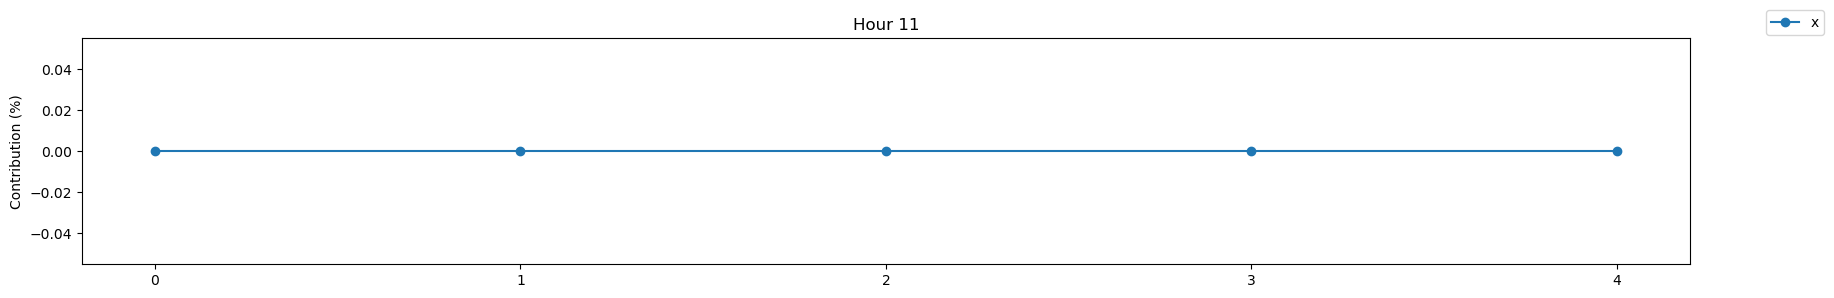

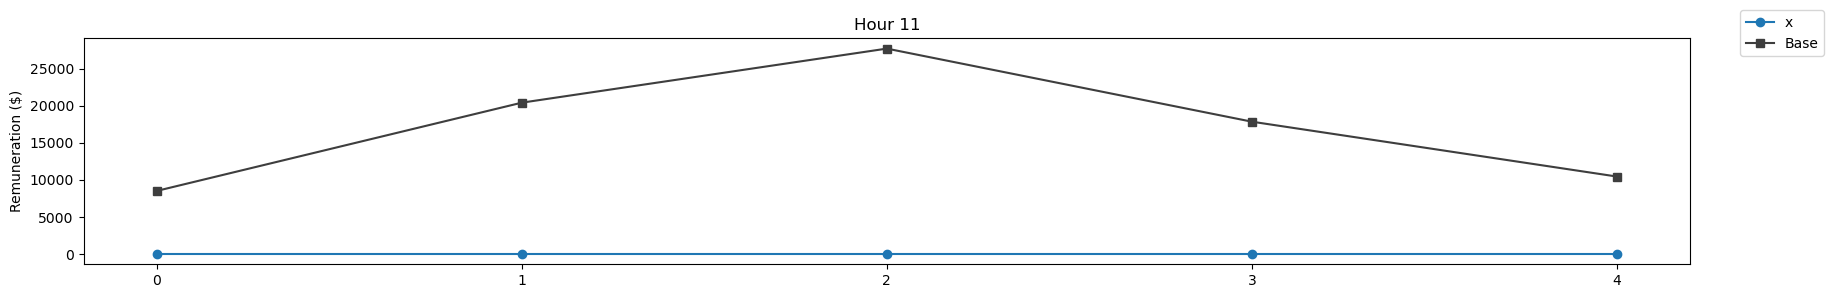

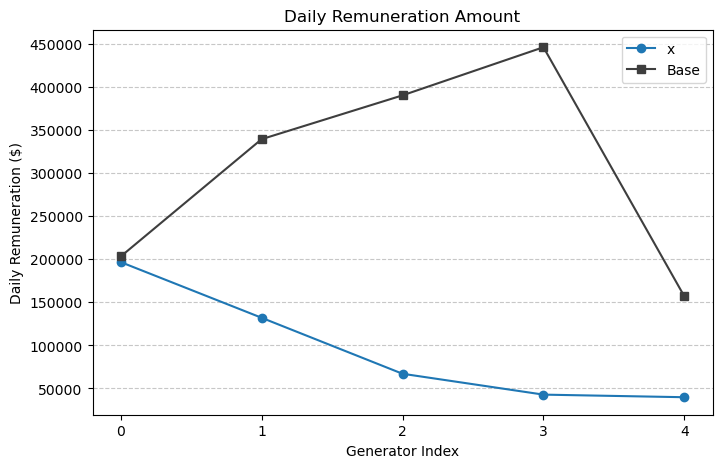

In [18]:
cx = hourly_contribution(x_vals)
plot_hourly_contribution(cx, labels=["x"], selected_hours=[11])
rhx, rdx = remuneration(cx, hourly_system_profit)
plot_hourly_remuneration(rhx, labels=["x"], selected_hours=[11])
plot_daily_remuneration(rdx, labels=["x"])

### 결과 저장

In [20]:
# set_profit_value = pd.DataFrame({'set_profit_value': der_profit})
# set_profit_value.to_csv('result/result_set1_profit.csv', index=False)

# set_obj = pd.DataFrame({'set_obj': [set.objVal]})
# set_obj.to_csv('result/result_set1_obj.csv', index=False)